# Gamma Trading - Esempio dal Capitolo 3 di Derman

## The Volatility Smile - Emanuel Derman, Michael B. Miller, David Park

Questo notebook replica l'esempio di **gamma trading** presentato nel Capitolo 3 del libro.

### Concetti chiave:
- **Delta hedging**: Neutralizzare la sensibilità al movimento del sottostante
- **Gamma**: La sensibilità del delta ai movimenti del sottostante
- **P&L da gamma trading**: Dipende dalla differenza tra volatilità realizzata e volatilità implicita
- **Long gamma** (long opzioni): Si guadagna quando la volatilità realizzata > volatilità implicita
- **Short gamma** (short opzioni): Si guadagna quando la volatilità realizzata < volatilità implicita


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Black-Scholes: Formule per Greeks

Implementiamo le formule Black-Scholes per calcolare il prezzo dell'opzione e i Greeks necessari per il delta hedging.


In [14]:
def black_scholes_call(S, K, T, r, sigma):
    """
    Calcola il prezzo di una call europea usando Black-Scholes
    
    Parameters:
    S: Prezzo spot del sottostante
    K: Strike price
    T: Time to maturity (anni)
    r: Risk-free rate
    sigma: Volatilità implicita
    """
    if T <= 0:
        return max(S - K, 0)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def black_scholes_put(S, K, T, r, sigma):
    """
    Calcola il prezzo di una put europea usando Black-Scholes
    """
    if T <= 0:
        return max(K - S, 0)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

def delta_call(S, K, T, r, sigma):
    """
    Calcola il delta di una call europea
    """
    if T <= 0:
        return 1.0 if S > K else 0.0
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def delta_put(S, K, T, r, sigma):
    """
    Calcola il delta di una put europea
    """
    if T <= 0:
        return -1.0 if S < K else 0.0
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) - 1

def gamma(S, K, T, r, sigma):
    """
    Calcola il gamma (uguale per call e put)
    """
    if T <= 0:
        return 0.0
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

def theta_call(S, K, T, r, sigma):
    """
    Calcola il theta di una call europea (per giorno)
    """
    if T <= 0:
        return 0.0
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) 
             - r * K * np.exp(-r * T) * norm.cdf(d2))
    
    return theta / 365  # Converti in theta giornaliero

def vega(S, K, T, r, sigma):
    """
    Calcola il vega (uguale per call e put)
    """
    if T <= 0:
        return 0.0
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T) / 100  # Diviso per 100 per ottenere il vega per 1% di vol


## 2. Simulazione del Prezzo del Sottostante

Simuliamo un path del sottostante usando un processo geometrico browniano con una **volatilità realizzata** specifica.


In [15]:
def simulate_gbm(S0, mu, sigma_realized, T, n_steps, seed=42):
    """
    Simula un Geometric Brownian Motion
    
    Parameters:
    S0: Prezzo iniziale
    mu: Drift (tasso di rendimento atteso)
    sigma_realized: Volatilità realizzata
    T: Tempo totale (anni)
    n_steps: Numero di step temporali
    seed: Random seed per riproducibilità
    
    Returns:
    prices: Array dei prezzi simulati
    times: Array dei tempi
    """
    np.random.seed(seed)
    
    dt = T / n_steps
    times = np.linspace(0, T, n_steps + 1)
    
    # Genera i movimenti browniani
    dW = np.random.normal(0, np.sqrt(dt), n_steps)
    
    # Inizializza l'array dei prezzi
    prices = np.zeros(n_steps + 1)
    prices[0] = S0
    
    # Simula il GBM
    for i in range(n_steps):
        prices[i + 1] = prices[i] * np.exp((mu - 0.5 * sigma_realized**2) * dt + sigma_realized * dW[i])
    
    return prices, times


## 3. Strategia di Gamma Trading con Delta Hedging

Implementiamo la strategia descritta nel Capitolo 3:
1. Compriamo un'opzione call ATM (long gamma)
2. Delta hedgiamo la posizione vendendo il sottostante
3. Re-hedgiamo periodicamente (rebalancing discreto)
4. Tracciamo il P&L totale


In [16]:
def gamma_trading_simulation(S0, K, T, r, sigma_implied, sigma_realized, 
                            n_steps, rehedge_frequency=1, seed=42):
    """
    Simula una strategia di gamma trading con delta hedging
    
    Parameters:
    S0: Prezzo iniziale del sottostante
    K: Strike dell'opzione
    T: Maturity dell'opzione (anni)
    r: Risk-free rate
    sigma_implied: Volatilità implicita usata per prezzare l'opzione
    sigma_realized: Volatilità realizzata del sottostante
    n_steps: Numero totale di step temporali
    rehedge_frequency: Ogni quanti step fare il rehedging (1 = ogni step)
    seed: Random seed
    
    Returns:
    DataFrame con i risultati della simulazione
    """
    # Simula il path del sottostante
    prices, times = simulate_gbm(S0, r, sigma_realized, T, n_steps, seed)
    
    # Inizializza gli array per memorizzare i risultati
    results = []
    
    # Prezzo iniziale dell'opzione
    initial_option_price = black_scholes_call(S0, K, T, r, sigma_implied)
    
    # Setup iniziale
    delta_hedge = 0  # Posizione nel sottostante (numero di shares)
    cash = -initial_option_price  # Cash account (paghiamo per l'opzione)
    
    for i in range(n_steps + 1):
        S = prices[i]
        t = times[i]
        time_to_maturity = T - t
        
        # Calcola il valore corrente dell'opzione e i Greeks
        if time_to_maturity > 0:
            option_value = black_scholes_call(S, K, time_to_maturity, r, sigma_implied)
            delta_option = delta_call(S, K, time_to_maturity, r, sigma_implied)
            gamma_option = gamma(S, K, time_to_maturity, r, sigma_implied)
            theta_option = theta_call(S, K, time_to_maturity, r, sigma_implied)
        else:
            option_value = max(S - K, 0)
            delta_option = 1.0 if S > K else 0.0
            gamma_option = 0.0
            theta_option = 0.0
        
        # Rehedging
        if i % rehedge_frequency == 0 and i < n_steps:
            # Delta target per neutralizzare l'esposizione
            delta_target = -delta_option  # Vendiamo il sottostante per neutralizzare
            delta_change = delta_target - delta_hedge
            
            # Aggiorna la posizione nel sottostante
            cash -= delta_change * S  # Vendiamo (negativo) o compriamo (positivo)
            delta_hedge = delta_target
        
        # Calcola il P&L totale
        portfolio_value = option_value + delta_hedge * S + cash
        
        # Salva i risultati
        results.append({
            'Time': t,
            'Days': t * 365,
            'Stock_Price': S,
            'Time_to_Maturity': time_to_maturity,
            'Option_Value': option_value,
            'Delta': delta_option,
            'Gamma': gamma_option,
            'Theta': theta_option,
            'Hedge_Position': delta_hedge,
            'Cash': cash,
            'Portfolio_Value': portfolio_value,
            'PnL': portfolio_value
        })
    
    return pd.DataFrame(results)


## 4. Esempio: Scenario Base (come nel libro di Derman)

Replichiamo l'esempio del Capitolo 3 con i seguenti parametri:
- Stock ATM: $S_0 = K = 100$
- Maturity: 1 mese (T = 1/12 anni)
- Risk-free rate: 5%
- Volatilità implicita: 20%
- Volatilità realizzata: 30% (maggiore dell'implicita)
- Rehedging: Giornaliero


In [17]:
# Parametri dell'esempio
S0 = 100.0          # Prezzo iniziale
K = 100.0           # Strike ATM
T = 1/12            # 1 mese
r = 0.05            # 5% risk-free rate
sigma_implied = 0.20   # 20% volatilità implicita
sigma_realized = 0.30  # 30% volatilità realizzata
n_steps = 21        # ~21 giorni di trading in un mese
rehedge_freq = 1    # Rehedge giornaliero

# Esegui la simulazione
df = gamma_trading_simulation(S0, K, T, r, sigma_implied, sigma_realized, 
                              n_steps, rehedge_frequency=rehedge_freq, seed=42)

# Mostra i primi risultati
print("="*80)
print("GAMMA TRADING SIMULATION - Scenario Base")
print("="*80)
print(f"Volatilità Implicita: {sigma_implied*100:.1f}%")
print(f"Volatilità Realizzata: {sigma_realized*100:.1f}%")
print(f"Differenza: {(sigma_realized - sigma_implied)*100:.1f}%")
print(f"\nPrezzo iniziale opzione: ${df.iloc[0]['Option_Value']:.4f}")
print(f"P&L finale: ${df.iloc[-1]['PnL']:.4f}")
print("="*80)

# Visualizza la tabella
display_cols = ['Days', 'Stock_Price', 'Option_Value', 'Delta', 'Gamma', 
                'Hedge_Position', 'PnL']
print("\nPrime e ultime righe della simulazione:")
print(df[display_cols].head(10))
print("...")
print(df[display_cols].tail(5))


GAMMA TRADING SIMULATION - Scenario Base
Volatilità Implicita: 20.0%
Volatilità Realizzata: 30.0%
Differenza: 10.0%

Prezzo iniziale opzione: $2.5121
P&L finale: $0.6490

Prime e ultime righe della simulazione:
        Days  Stock_Price  Option_Value     Delta     Gamma  Hedge_Position  \
0   0.000000   100.000000      2.512067  0.540239  0.068747       -0.540239   
1   1.448413   100.945124      2.987424  0.604710  0.067712       -0.604710   
2   2.896825   100.683701      2.764556  0.587134  0.070423       -0.587134   
3   4.345238   101.925682      3.479961  0.673781  0.066163       -0.673781   
4   5.793651   104.904073      5.694665  0.844363  0.043846       -0.844363   
5   7.242063   104.442961      5.252470  0.829145  0.048232       -0.829145   
6   8.690476   103.983909      4.816060  0.812193  0.053101       -0.812193   
7  10.138889   107.136136      7.549554  0.938794  0.023957       -0.938794   
8  11.587302   108.703427      9.014139  0.972358  0.012873       -0.972358   

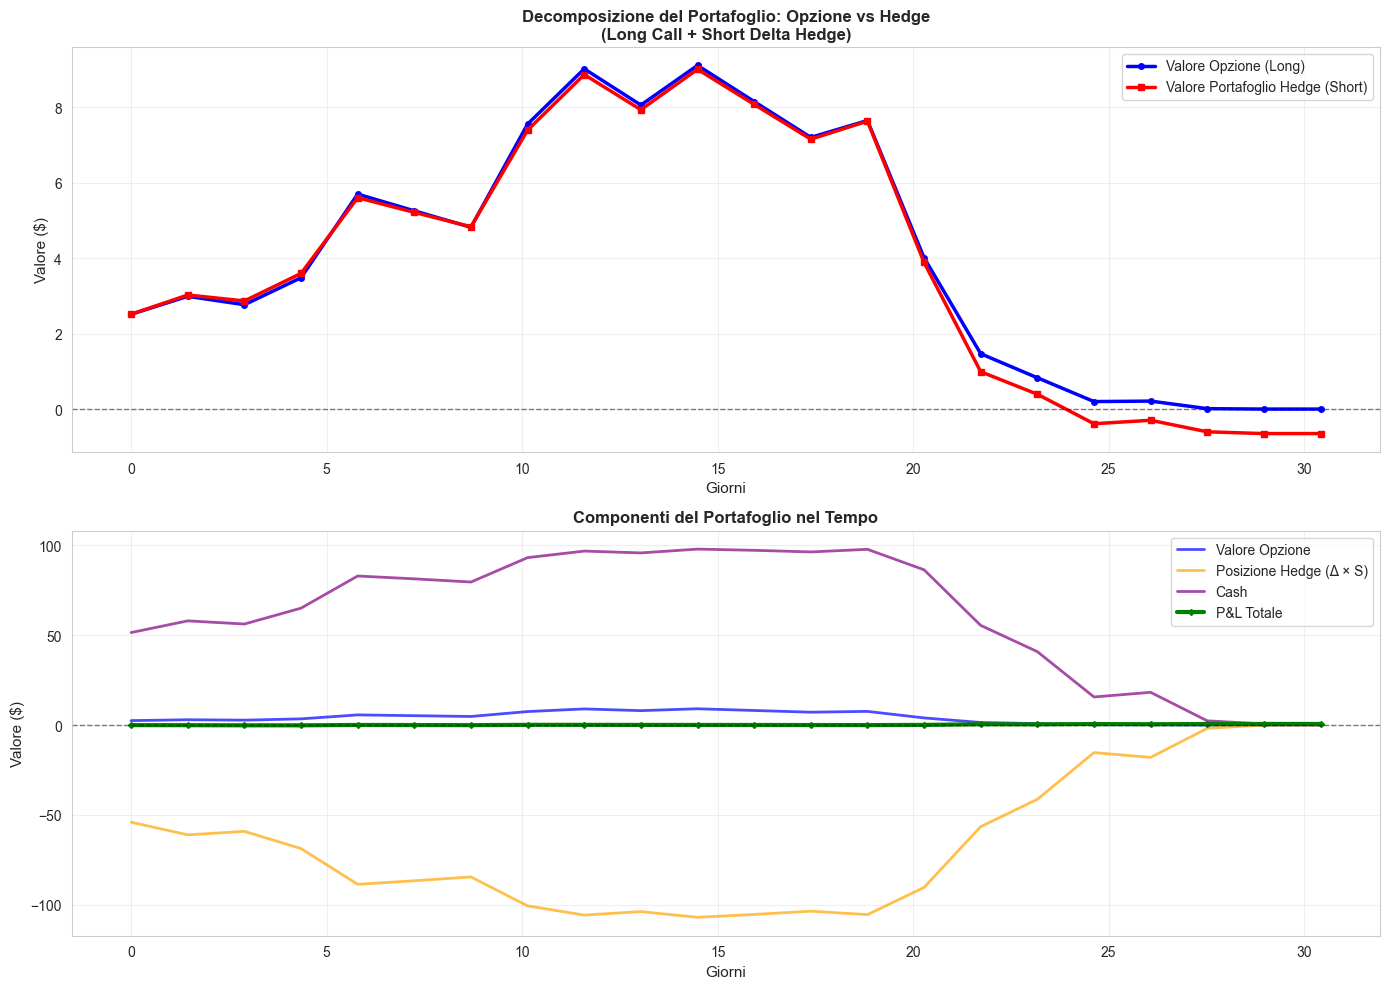


Analisi del bilanciamento:
Valore finale opzione: $0.0000
Valore finale hedge: $-0.6490
Cash finale: $0.6490
P&L finale: $0.6490


In [30]:
# Visualizzazione: Opzione vs Portafoglio di Hedge
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Calcola il valore del portafoglio di hedge
df['Hedge_Portfolio_Value'] = df['Hedge_Position'] * df['Stock_Price'] + df['Cash']

# Grafico 1: Valore Opzione vs Valore Portafoglio di Hedge
ax1 = axes[0]
ax1.plot(df['Days'], df['Option_Value'], 'b-', linewidth=2.5, label='Valore Opzione (Long)', marker='o', markersize=4)
ax1.plot(df['Days'], -df['Hedge_Portfolio_Value'], 'r-', linewidth=2.5, label='Valore Portafoglio Hedge (Short)', marker='s', markersize=4)
ax1.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Giorni', fontsize=11)
ax1.set_ylabel('Valore ($)', fontsize=11)
ax1.set_title('Decomposizione del Portafoglio: Opzione vs Hedge\n(Long Call + Short Delta Hedge)', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Grafico 2: Componenti del Portafoglio e P&L
ax2 = axes[1]
ax2.plot(df['Days'], df['Option_Value'], 'b-', linewidth=2, label='Valore Opzione', alpha=0.7)
ax2.plot(df['Days'], df['Hedge_Position'] * df['Stock_Price'], 'orange', linewidth=2, label='Posizione Hedge (Δ × S)', alpha=0.7)
ax2.plot(df['Days'], df['Cash'], 'purple', linewidth=2, label='Cash', alpha=0.7)
ax2.plot(df['Days'], df['PnL'], 'g-', linewidth=3, label='P&L Totale', marker='D', markersize=3)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Giorni', fontsize=11)
ax2.set_ylabel('Valore ($)', fontsize=11)
ax2.set_title('Componenti del Portafoglio nel Tempo', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAnalisi del bilanciamento:")
print(f"Valore finale opzione: ${df.iloc[-1]['Option_Value']:.4f}")
print(f"Valore finale hedge: ${-df.iloc[-1]['Hedge_Portfolio_Value']:.4f}")
print(f"Cash finale: ${df.iloc[-1]['Cash']:.4f}")
print(f"P&L finale: ${df.iloc[-1]['PnL']:.4f}")


## 5. Visualizzazione dei Risultati


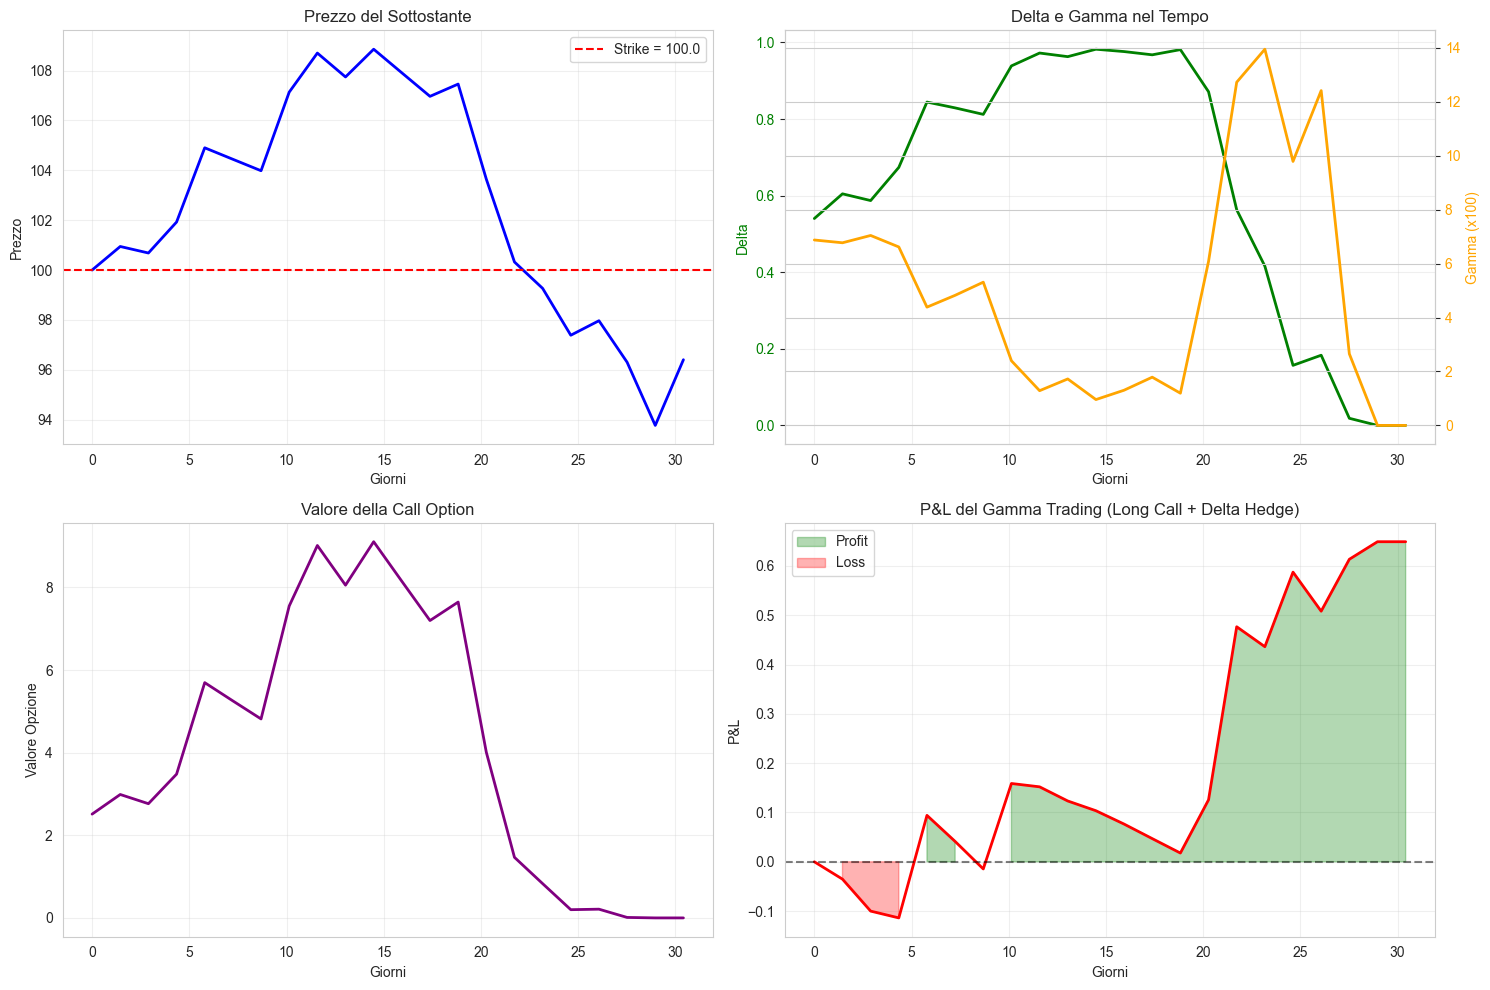

In [18]:
# Crea i grafici
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Prezzo del sottostante
axes[0, 0].plot(df['Days'], df['Stock_Price'], 'b-', linewidth=2)
axes[0, 0].axhline(y=K, color='r', linestyle='--', label=f'Strike = {K}')
axes[0, 0].set_xlabel('Giorni')
axes[0, 0].set_ylabel('Prezzo')
axes[0, 0].set_title('Prezzo del Sottostante')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Delta e Gamma
ax2 = axes[0, 1]
ax2.plot(df['Days'], df['Delta'], 'g-', linewidth=2, label='Delta')
ax2.set_xlabel('Giorni')
ax2.set_ylabel('Delta', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_title('Delta e Gamma nel Tempo')
ax2.grid(True, alpha=0.3)

ax2_twin = ax2.twinx()
ax2_twin.plot(df['Days'], df['Gamma']*100, 'orange', linewidth=2, label='Gamma (x100)')
ax2_twin.set_ylabel('Gamma (x100)', color='orange')
ax2_twin.tick_params(axis='y', labelcolor='orange')

# 3. Valore dell'opzione
axes[1, 0].plot(df['Days'], df['Option_Value'], 'purple', linewidth=2)
axes[1, 0].set_xlabel('Giorni')
axes[1, 0].set_ylabel('Valore Opzione')
axes[1, 0].set_title('Valore della Call Option')
axes[1, 0].grid(True, alpha=0.3)

# 4. P&L cumulativo
axes[1, 1].plot(df['Days'], df['PnL'], 'r-', linewidth=2)
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Giorni')
axes[1, 1].set_ylabel('P&L')
axes[1, 1].set_title('P&L del Gamma Trading (Long Call + Delta Hedge)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].fill_between(df['Days'], 0, df['PnL'], where=(df['PnL'] >= 0), 
                        alpha=0.3, color='green', label='Profit')
axes[1, 1].fill_between(df['Days'], 0, df['PnL'], where=(df['PnL'] < 0), 
                        alpha=0.3, color='red', label='Loss')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


## 6. Analisi: Volatilità Realizzata vs. Implicita

Il punto chiave del Capitolo 3 di Derman è che il **P&L del gamma trading dipende dalla differenza tra volatilità realizzata e volatilità implicita**.

Testiamo questa relazione con diversi scenari:


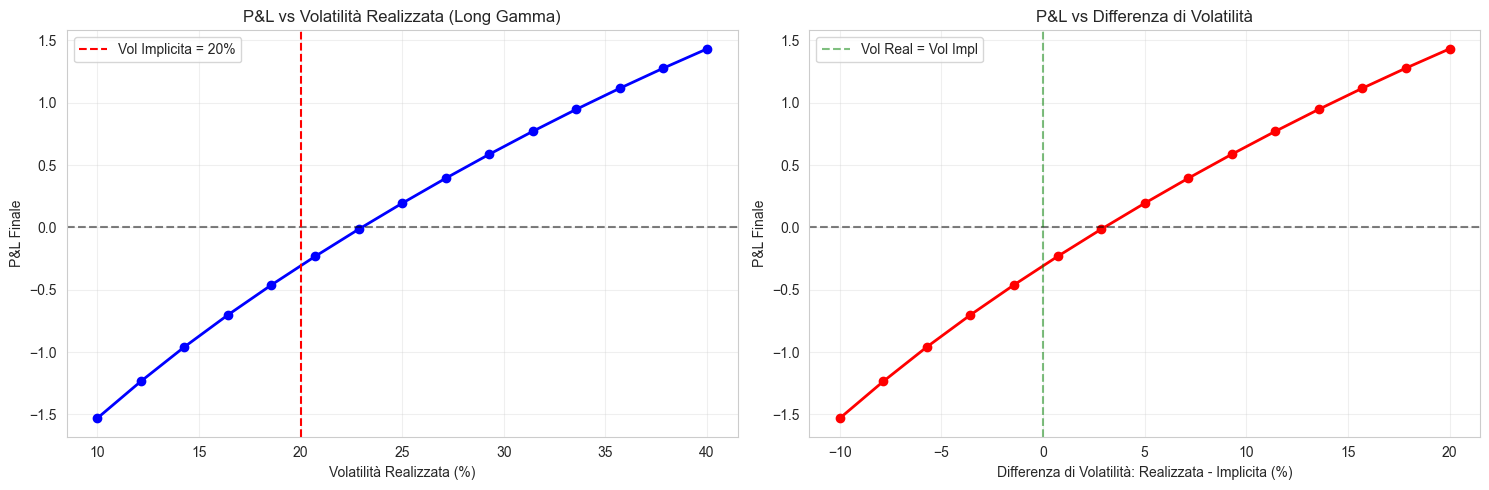


Risultati del confronto:
 Realized_Vol  Implied_Vol   Vol_Diff  Final_PnL
    10.000000         20.0 -10.000000  -1.530169
    12.142857         20.0  -7.857143  -1.234455
    14.285714         20.0  -5.714286  -0.958264
    16.428571         20.0  -3.571429  -0.701464
    18.571429         20.0  -1.428571  -0.460702
    20.714286         20.0   0.714286  -0.232576
    22.857143         20.0   2.857143  -0.014783
    25.000000         20.0   5.000000   0.193963
    27.142857         20.0   7.142857   0.394324
    29.285714         20.0   9.285714   0.586633
    31.428571         20.0  11.428571   0.771059
    33.571429         20.0  13.571429   0.947702
    35.714286         20.0  15.714286   1.116662
    37.857143         20.0  17.857143   1.278092
    40.000000         20.0  20.000000   1.432225


In [19]:
# Test con diverse volatilità realizzate
sigma_impl = 0.20
sigma_real_values = np.linspace(0.10, 0.40, 15)

results_comparison = []

for sigma_real in sigma_real_values:
    df_temp = gamma_trading_simulation(S0, K, T, r, sigma_impl, sigma_real, 
                                       n_steps, rehedge_frequency=rehedge_freq, seed=42)
    final_pnl = df_temp.iloc[-1]['PnL']
    
    results_comparison.append({
        'Realized_Vol': sigma_real * 100,
        'Implied_Vol': sigma_impl * 100,
        'Vol_Diff': (sigma_real - sigma_impl) * 100,
        'Final_PnL': final_pnl
    })

df_comparison = pd.DataFrame(results_comparison)

# Visualizza i risultati
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Grafico 1: P&L vs Volatilità Realizzata
axes[0].plot(df_comparison['Realized_Vol'], df_comparison['Final_PnL'], 
             'bo-', linewidth=2, markersize=6)
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[0].axvline(x=sigma_impl*100, color='r', linestyle='--', 
                label=f'Vol Implicita = {sigma_impl*100:.0f}%')
axes[0].set_xlabel('Volatilità Realizzata (%)')
axes[0].set_ylabel('P&L Finale')
axes[0].set_title('P&L vs Volatilità Realizzata (Long Gamma)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Grafico 2: P&L vs Differenza di Volatilità
axes[1].plot(df_comparison['Vol_Diff'], df_comparison['Final_PnL'], 
             'ro-', linewidth=2, markersize=6)
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1].axvline(x=0, color='g', linestyle='--', alpha=0.5, label='Vol Real = Vol Impl')
axes[1].set_xlabel('Differenza di Volatilità: Realizzata - Implicita (%)')
axes[1].set_ylabel('P&L Finale')
axes[1].set_title('P&L vs Differenza di Volatilità')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRisultati del confronto:")
print(df_comparison.to_string(index=False))


## 7. Interpretazione dei Risultati

### Punti chiave dall'esempio di Derman:

1. **Long Gamma (Long Option)**:
   - Profitto quando: Volatilità Realizzata > Volatilità Implicita
   - Il guadagno deriva dal rehedging: si vende alto e si compra basso
   - Si paga il theta (time decay) ma si guadagna dal movimento

2. **Short Gamma (Short Option)**:
   - Profitto quando: Volatilità Realizzata < Volatilità Implicita
   - Si raccoglie il premio dell'opzione (theta positivo)
   - Si perde quando il mercato si muove troppo

3. **Break-even**:
   - Il P&L è approssimativamente zero quando Vol Realizzata ≈ Vol Implicita
   - Questo è il punto di equilibrio del gamma trading

4. **Frequenza di Rehedging**:
   - Maggiore frequenza → più vicini alla teoria di Black-Scholes
   - Minore frequenza → maggiore tracking error e costi di transazione ridotti


## 8. Effetto della Frequenza di Rehedging

Testiamo come la frequenza del rehedging influenza il P&L:


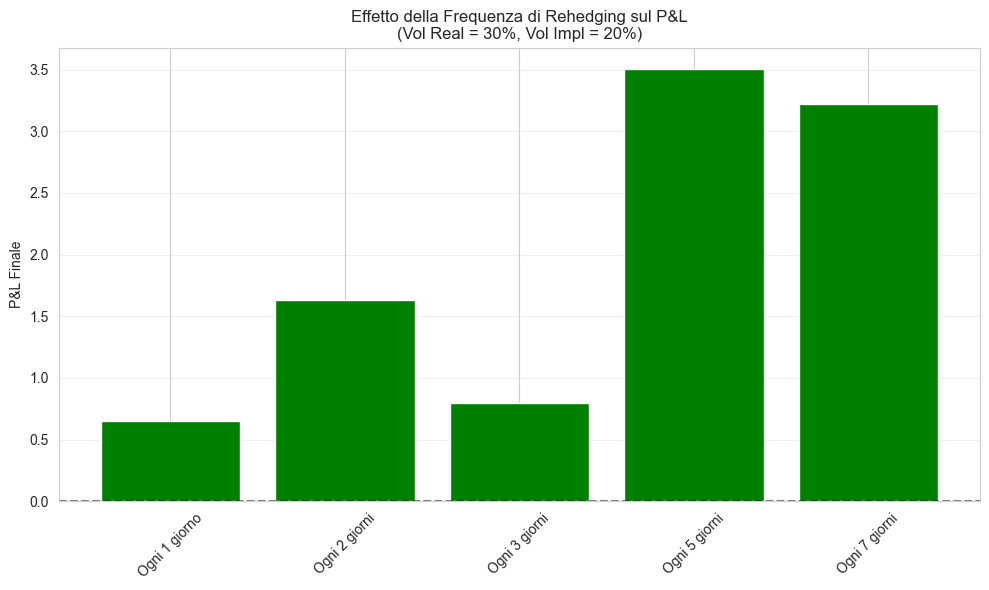


Effetto della frequenza di rehedging:
 Rehedge_Frequency Rehedge_Description  Final_PnL
                 1       Ogni 1 giorno   0.648979
                 2       Ogni 2 giorni   1.631956
                 3       Ogni 3 giorni   0.797574
                 5       Ogni 5 giorni   3.501701
                 7       Ogni 7 giorni   3.219902


In [20]:
# Test con diverse frequenze di rehedging
rehedge_frequencies = [1, 2, 3, 5, 7]  # 1 = giornaliero, 7 = settimanale
sigma_impl = 0.20
sigma_real = 0.30

results_rehedge = []

for freq in rehedge_frequencies:
    df_temp = gamma_trading_simulation(S0, K, T, r, sigma_impl, sigma_real, 
                                       n_steps, rehedge_frequency=freq, seed=42)
    final_pnl = df_temp.iloc[-1]['PnL']
    
    results_rehedge.append({
        'Rehedge_Frequency': freq,
        'Rehedge_Description': f'Ogni {freq} giorn{"o" if freq == 1 else "i"}',
        'Final_PnL': final_pnl
    })

df_rehedge = pd.DataFrame(results_rehedge)

# Visualizza
plt.figure(figsize=(10, 6))
plt.bar(range(len(df_rehedge)), df_rehedge['Final_PnL'], 
        color=['green' if x > 0 else 'red' for x in df_rehedge['Final_PnL']])
plt.xticks(range(len(df_rehedge)), df_rehedge['Rehedge_Description'], rotation=45)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.ylabel('P&L Finale')
plt.title('Effetto della Frequenza di Rehedging sul P&L\n(Vol Real = 30%, Vol Impl = 20%)')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nEffetto della frequenza di rehedging:")
print(df_rehedge.to_string(index=False))


## 9. Formula Approssimata del P&L da Gamma Trading

Derman presenta una formula approssimata per il P&L atteso dal gamma trading:

$$
\text{PnL} \approx \frac{1}{2} \Gamma S^2 (\sigma_{\text{real}}^2 - \sigma_{\text{impl}}^2) T
$$

Dove:
- $\Gamma$ = Gamma dell'opzione
- $S$ = Prezzo del sottostante
- $\sigma_{\text{real}}$ = Volatilità realizzata
- $\sigma_{\text{impl}}$ = Volatilità implicita
- $T$ = Time to maturity

Verifichiamo questa formula:


In [35]:
# Calcola il P&L teorico usando la formula approssimata
S = S0
K = 100.0
T_maturity = T
sigma_impl = 0.20
sigma_real = 0.30

# Calcola il gamma iniziale
gamma_initial = gamma(S, K, T_maturity, r, sigma_impl)

# Formula approssimata di Derman
theoretical_pnl = 0.5 * gamma_initial * S**2 * (sigma_real**2 - sigma_impl**2) * T_maturity

# P&L dalla simulazione
df_actual = gamma_trading_simulation(S0, K, T, r, sigma_impl, sigma_real, 
                                     1000, rehedge_frequency=1, seed=42)
actual_pnl = df_actual.iloc[-1]['PnL']

print("="*80)
print("CONFRONTO: Formula Teorica vs Simulazione")
print("="*80)
print(f"Gamma iniziale: {gamma_initial:.6f}")
print(f"Volatilità Implicita: {sigma_impl*100:.1f}%")
print(f"Volatilità Realizzata: {sigma_real*100:.1f}%")
print(f"Differenza di varianza: {(sigma_real**2 - sigma_impl**2):.4f}")
print(f"\nP&L Teorico (Formula): ${theoretical_pnl:.4f}")
print(f"P&L Simulato: ${actual_pnl:.4f}")
print(f"Differenza: ${abs(theoretical_pnl - actual_pnl):.4f}")
print(f"Errore percentuale: {abs(theoretical_pnl - actual_pnl) / abs(theoretical_pnl) * 100:.2f}%")
print("="*80)


CONFRONTO: Formula Teorica vs Simulazione
Gamma iniziale: 0.069228
Volatilità Implicita: 20.0%
Volatilità Realizzata: 30.0%
Differenza di varianza: 0.0500

P&L Teorico (Formula): $1.4225
P&L Simulato: $1.3732
Differenza: $0.0493
Errore percentuale: 3.47%


### Differenze tra Formula Analitica e Simulazione Numerica

Le differenze tra il P&L teorico (formula) e il P&L simulato derivano da diverse **assunzioni e approssimazioni**:

#### 1. **Discretizzazione del Rehedging**
- **Formula analitica**: Assume **delta hedging continuo** (rehedging istantaneo ad ogni infinitesimo movimento)
- **Simulazione**: Usa **rehedging discreto** (es. una volta al giorno)
  - Tra un rehedging e l'altro, il portafoglio non è perfettamente delta-neutrale
  - Questo introduce un "tracking error" che può essere positivo o negativo

#### 2. **Gamma Costante vs Variabile**
- **Formula analitica**: Usa il **Gamma iniziale** costante per tutta la durata
  $$\text{P&L} \approx \frac{1}{2} \Gamma_0 S^2 (\sigma_{\text{real}}^2 - \sigma_{\text{impl}}^2) T$$
  
- **Simulazione**: Il **Gamma cambia** ad ogni step in funzione di:
  - Movimento del sottostante S(t)
  - Tempo residuo a scadenza (T-t)
  - Moneyness dell'opzione
  
  Il Gamma è massimo ATM e diminuisce quando l'opzione diventa ITM/OTM o si avvicina a scadenza.

#### 3. **Approssimazione di Taylor**
- **Formula analitica**: È un'**approssimazione al secondo ordine** (espansione di Taylor):
  $$\Delta V_{\text{opzione}} \approx \Delta \cdot \Delta S + \frac{1}{2}\Gamma \cdot (\Delta S)^2 + \Theta \cdot \Delta t$$
  
  Trascura i termini di ordine superiore (es. derivate del Gamma, cross-derivatives, etc.)

- **Simulazione**: Usa il **pricing esatto** di Black-Scholes ad ogni step, quindi non fa approssimazioni di Taylor

#### 4. **Path Dependence**
- **Formula analitica**: Fornisce il **valore atteso** del P&L
  - Assume che la varianza realizzata sia distribuita uniformemente nel tempo
  - Non dipende dal path specifico preso dal sottostante

- **Simulazione**: È **path-dependent**
  - Il P&L dipende dal path specifico simulato
  - Diversi path con la stessa volatilità realizzata possono dare P&L diversi
  - È per questo che nelle simulazioni Monte Carlo vediamo una distribuzione di P&L

#### 5. **Effetti di Ordine Superiore**
La formula trascura effetti come:
- **Vanna** (∂²V/∂S∂σ): Sensibilità del delta alla volatilità
- **Volga** (∂²V/∂σ²): Convessità rispetto alla volatilità
- **Charm** (∂²V/∂S∂t): Variazione del delta nel tempo

La simulazione cattura implicitamente questi effetti ricalcolando i Greeks ad ogni step.

#### 6. **Quale Approccio è Migliore?**

**Formula analitica**:
- ✅ Rapida, intuitiva, fornisce insight teorico
- ✅ Utile per stimare il P&L atteso "quick and dirty"
- ❌ Meno accurata, specialmente per opzioni vicine a scadenza o molto ITM/OTM

**Simulazione numerica**:
- ✅ Più accurata, cattura tutti gli effetti non-lineari
- ✅ Mostra la variabilità del P&L (distribuzione)
- ❌ Più lenta computazionalmente
- ❌ Path-dependent (serve Monte Carlo per avere distribuzione completa)

**In pratica**:
- I trader usano entrambi: la formula per stime rapide, le simulazioni per risk management dettagliato
- L'errore tipico è **5-20%** per opzioni ragionevolmente vicine a ATM
- L'errore aumenta per opzioni molto ITM/OTM o molto vicine a scadenza


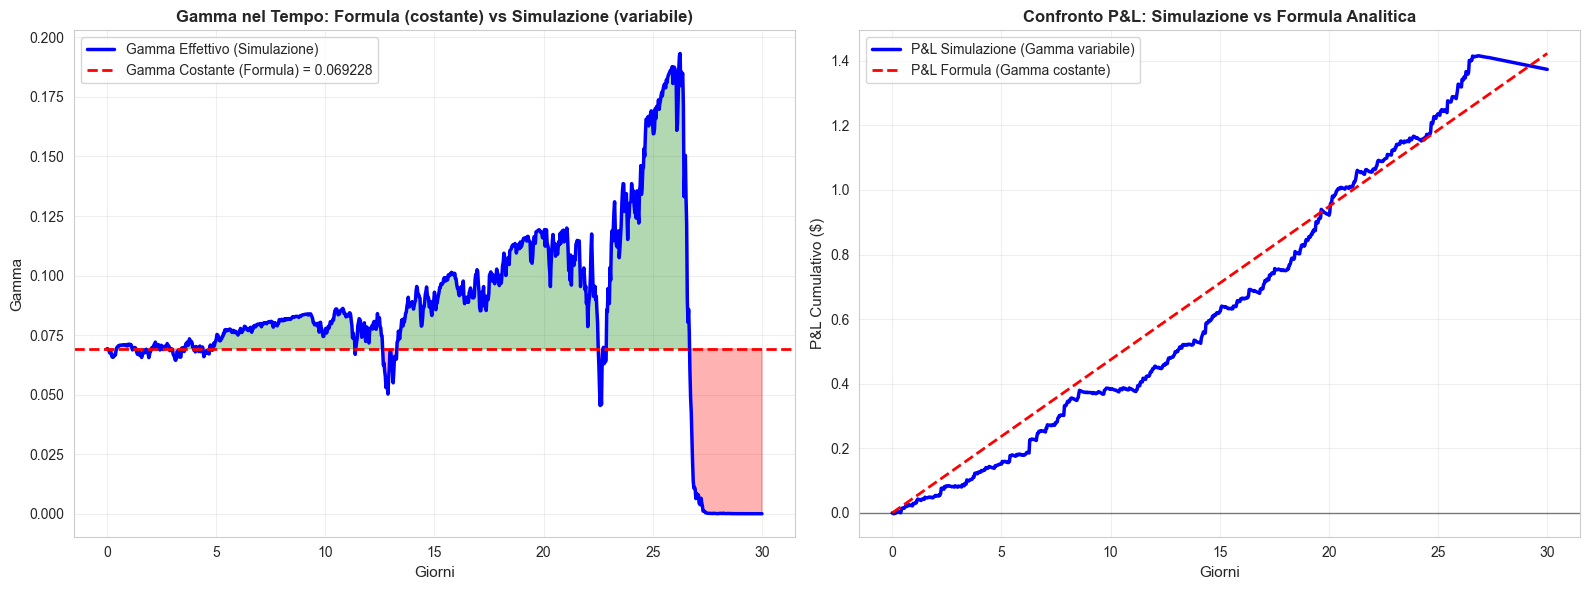


Analisi della differenza:
Gamma medio simulazione: 0.083462
Gamma costante (formula): 0.069228
Differenza: 0.014235 (20.6%)

P&L finale simulazione: $1.3732
P&L teorico (formula): $1.4225
Errore assoluto: $0.0493
Errore percentuale: 3.47%


In [36]:
# Visualizzazione: Gamma Variabile vs Costante
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Usa i dati della simulazione precedente
ax1 = axes[0]
ax1.plot(df_actual['Days'], df_actual['Gamma'], 'b-', linewidth=2.5, label='Gamma Effettivo (Simulazione)')
ax1.axhline(y=gamma_initial, color='r', linestyle='--', linewidth=2, label=f'Gamma Costante (Formula) = {gamma_initial:.6f}')
ax1.set_xlabel('Giorni', fontsize=11)
ax1.set_ylabel('Gamma', fontsize=11)
ax1.set_title('Gamma nel Tempo: Formula (costante) vs Simulazione (variabile)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.fill_between(df_actual['Days'], gamma_initial, df_actual['Gamma'], 
                 where=(df_actual['Gamma'] >= gamma_initial), alpha=0.3, color='green', label='Gamma > costante')
ax1.fill_between(df_actual['Days'], gamma_initial, df_actual['Gamma'], 
                 where=(df_actual['Gamma'] < gamma_initial), alpha=0.3, color='red', label='Gamma < costante')

# Calcola il P&L cumulativo usando gamma costante (approssimazione)
ax2 = axes[1]
# P&L approssimato ad ogni step usando la formula con gamma costante
pnl_approx_cumulative = []
for i in range(len(df_actual)):
    t = df_actual.iloc[i]['Time']
    # Approssimazione: P&L proporzionale al tempo trascorso
    pnl_approx = theoretical_pnl * (t / T_maturity) if T_maturity > 0 else 0
    pnl_approx_cumulative.append(pnl_approx)

ax2.plot(df_actual['Days'], df_actual['PnL'], 'b-', linewidth=2.5, label='P&L Simulazione (Gamma variabile)')
ax2.plot(df_actual['Days'], pnl_approx_cumulative, 'r--', linewidth=2, label='P&L Formula (Gamma costante)')
ax2.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.5)
ax2.set_xlabel('Giorni', fontsize=11)
ax2.set_ylabel('P&L Cumulativo ($)', fontsize=11)
ax2.set_title('Confronto P&L: Simulazione vs Formula Analitica', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAnalisi della differenza:")
print(f"Gamma medio simulazione: {df_actual['Gamma'].mean():.6f}")
print(f"Gamma costante (formula): {gamma_initial:.6f}")
print(f"Differenza: {abs(df_actual['Gamma'].mean() - gamma_initial):.6f} ({abs(df_actual['Gamma'].mean() - gamma_initial)/gamma_initial*100:.1f}%)")
print(f"\nP&L finale simulazione: ${df_actual.iloc[-1]['PnL']:.4f}")
print(f"P&L teorico (formula): ${theoretical_pnl:.4f}")
print(f"Errore assoluto: ${abs(df_actual.iloc[-1]['PnL'] - theoretical_pnl):.4f}")
print(f"Errore percentuale: {abs(df_actual.iloc[-1]['PnL'] - theoretical_pnl)/abs(theoretical_pnl)*100:.2f}%")


## 10. Multiple Simulazioni (Monte Carlo)

Eseguiamo multiple simulazioni per vedere la distribuzione dei P&L:


Eseguendo 10000 simulazioni Monte Carlo...
  Completate 100/10000 simulazioni
  Completate 200/10000 simulazioni
  Completate 300/10000 simulazioni
  Completate 400/10000 simulazioni
  Completate 500/10000 simulazioni
  Completate 600/10000 simulazioni
  Completate 700/10000 simulazioni
  Completate 800/10000 simulazioni
  Completate 900/10000 simulazioni
  Completate 1000/10000 simulazioni
  Completate 1100/10000 simulazioni
  Completate 1200/10000 simulazioni
  Completate 1300/10000 simulazioni
  Completate 1400/10000 simulazioni
  Completate 1500/10000 simulazioni
  Completate 1600/10000 simulazioni
  Completate 1700/10000 simulazioni
  Completate 1800/10000 simulazioni
  Completate 1900/10000 simulazioni
  Completate 2000/10000 simulazioni
  Completate 2100/10000 simulazioni
  Completate 2200/10000 simulazioni
  Completate 2300/10000 simulazioni
  Completate 2400/10000 simulazioni
  Completate 2500/10000 simulazioni
  Completate 2600/10000 simulazioni
  Completate 2700/10000 simula

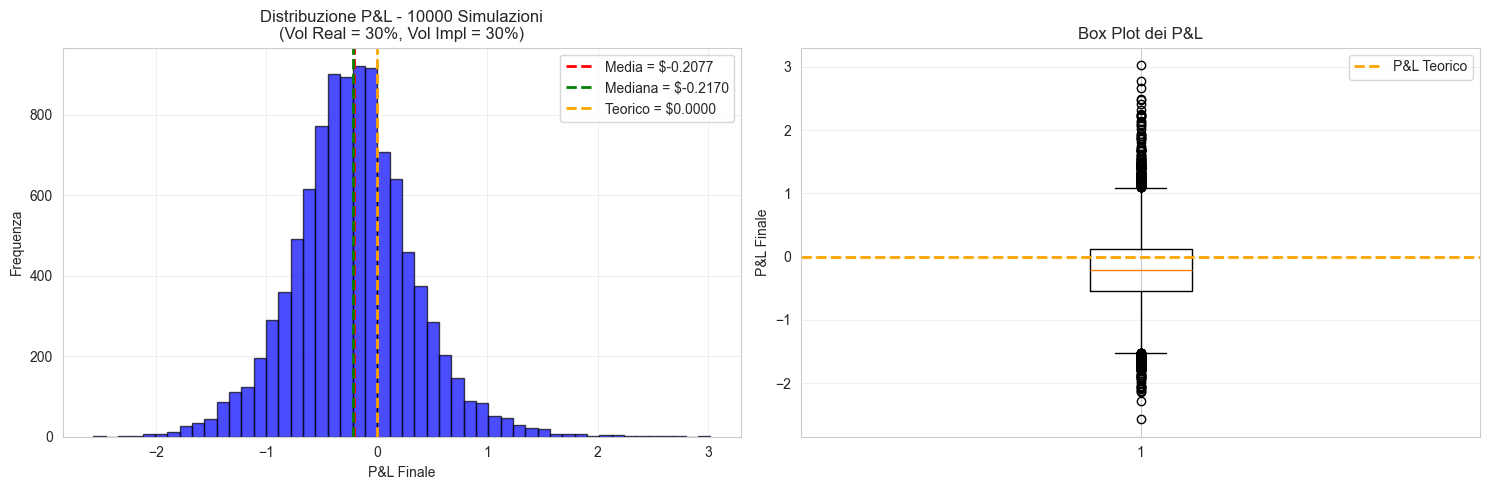


RISULTATI SIMULAZIONI MONTE CARLO vs FORMULA TEORICA

Parametri:
  Numero di simulazioni: 10000
  Volatilità Implicita: 30.0%
  Volatilità Realizzata: 30.0%
  Gamma iniziale: 0.046194

Formula Teorica (Derman):
  P&L Teorico = ½ × Γ × S² × (σ²ᵣₑₐₗ - σ²ᵢₘₚₗ) × T
  P&L Teorico = $0.0000

Statistiche Monte Carlo:
  P&L Medio:             $-0.2077
  P&L Mediano:           $-0.2170
  Deviazione Standard:   $0.5486
  P&L Minimo:            $-2.5681
  P&L Massimo:           $3.0218

Confronto Formula vs Simulazione:
  Errore Assoluto:       $0.2077
  Errore Percentuale:    0.00%
  Convergenza:           Eccellente

Altri Insights:
  % Simulazioni Profitable: 32.2%
  Intervallo di Confidenza 95%: [$-1.2830, $0.8676]
  Formula dentro IC 95%: Sì ✓


In [ ]:
def monte_carlo_comparison(n_sim, sigma_impl, sigma_real, S0=100, K=100, T=1/12, r=0.05, n_steps=21):
    """
    Esegue simulazioni Monte Carlo e confronta con la formula teorica
    
    Parameters:
    -----------
    n_sim : int
        Numero di simulazioni Monte Carlo
    sigma_impl : float
        Volatilità implicita (usata per prezzare l'opzione)
    sigma_real : float
        Volatilità realizzata (del sottostante simulato)
    S0, K, T, r, n_steps : parametri opzionali per la simulazione
    
    Returns:
    --------
    dict : Dizionario con statistiche e risultati
    """
    # 1. Calcola P&L teorico usando la formula analitica
    gamma_initial = gamma(S0, K, T, r, sigma_impl)
    theoretical_pnl = 0.5 * gamma_initial * S0**2 * (sigma_real**2 - sigma_impl**2) * T
    
    # 2. Esegui simulazioni Monte Carlo
    pnl_results = []
    print(f"Eseguendo {n_sim} simulazioni Monte Carlo...")
    
    for i in range(n_sim):
        if i % 100 == 0 and i > 0:
            print(f"  Completate {i}/{n_sim} simulazioni")
        
        df_sim = gamma_trading_simulation(S0, K, T, r, sigma_impl, sigma_real, 
                                         n_steps, rehedge_frequency=1, seed=i)
        pnl_results.append(df_sim.iloc[-1]['PnL'])
    
    pnl_results = np.array(pnl_results)
    
    # 3. Calcola statistiche
    mean_pnl = np.mean(pnl_results)
    std_pnl = np.std(pnl_results)
    median_pnl = np.median(pnl_results)
    min_pnl = np.min(pnl_results)
    max_pnl = np.max(pnl_results)
    
    # 4. Calcola errori
    error_mean = abs(mean_pnl - theoretical_pnl)
    error_pct = (error_mean / abs(theoretical_pnl)) * 100 if theoretical_pnl != 0 else 0
    
    # 5. Restituisci risultati
    results = {
        'n_simulations': n_sim,
        'sigma_impl': sigma_impl,
        'sigma_real': sigma_real,
        'theoretical_pnl': theoretical_pnl,
        'gamma_initial': gamma_initial,
        'pnl_array': pnl_results,
        'mean_pnl': mean_pnl,
        'std_pnl': std_pnl,
        'median_pnl': median_pnl,
        'min_pnl': min_pnl,
        'max_pnl': max_pnl,
        'error_abs': error_mean,
        'error_pct': error_pct,
        'pct_profitable': (pnl_results > 0).sum() / n_sim * 100
    }
    
    return results

# Esegui la funzione con i parametri
n_simulations = 10000
sigma_impl = 0.20
sigma_real = 0.30

results = monte_carlo_comparison(n_sim=n_simulations, 
                                 sigma_impl=sigma_impl, 
                                 sigma_real=sigma_real,
                                 S0=S0, K=K, T=T, r=r, n_steps=n_steps)

# Estrai i risultati
pnl_results = results['pnl_array']
mean_pnl = results['mean_pnl']
std_pnl = results['std_pnl']
median_pnl = results['median_pnl']
theoretical_pnl = results['theoretical_pnl']

# Statistiche
mean_pnl = np.mean(pnl_results)
std_pnl = np.std(pnl_results)
median_pnl = np.median(pnl_results)

# Visualizza la distribuzione
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Istogramma
axes[0].hist(pnl_results, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(mean_pnl, color='red', linestyle='--', linewidth=2, label=f'Media = ${mean_pnl:.4f}')
axes[0].axvline(median_pnl, color='green', linestyle='--', linewidth=2, label=f'Mediana = ${median_pnl:.4f}')
axes[0].axvline(theoretical_pnl, color='orange', linestyle='--', linewidth=2, label=f'Teorico = ${theoretical_pnl:.4f}')
axes[0].set_xlabel('P&L Finale')
axes[0].set_ylabel('Frequenza')
axes[0].set_title(f'Distribuzione P&L - {n_simulations} Simulazioni\n(Vol Real = {sigma_real*100:.0f}%, Vol Impl = {sigma_impl*100:.0f}%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(pnl_results, vert=True)
axes[1].axhline(theoretical_pnl, color='orange', linestyle='--', linewidth=2, label='P&L Teorico')
axes[1].set_ylabel('P&L Finale')
axes[1].set_title('Box Plot dei P&L')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("RISULTATI SIMULAZIONI MONTE CARLO vs FORMULA TEORICA")
print("="*80)
print(f"\nParametri:")
print(f"  Numero di simulazioni: {results['n_simulations']}")
print(f"  Volatilità Implicita: {results['sigma_impl']*100:.1f}%")
print(f"  Volatilità Realizzata: {results['sigma_real']*100:.1f}%")
print(f"  Gamma iniziale: {results['gamma_initial']:.6f}")

print(f"\nFormula Teorica (Derman):")
print(f"  P&L Teorico = ½ × Γ × S² × (σ²ᵣₑₐₗ - σ²ᵢₘₚₗ) × T")
print(f"  P&L Teorico = ${results['theoretical_pnl']:.4f}")

print(f"\nStatistiche Monte Carlo:")
print(f"  P&L Medio:             ${results['mean_pnl']:.4f}")
print(f"  P&L Mediano:           ${results['median_pnl']:.4f}")
print(f"  Deviazione Standard:   ${results['std_pnl']:.4f}")
print(f"  P&L Minimo:            ${results['min_pnl']:.4f}")
print(f"  P&L Massimo:           ${results['max_pnl']:.4f}")

print(f"\nConfronto Formula vs Simulazione:")
print(f"  Errore Assoluto:       ${results['error_abs']:.4f}")
print(f"  Errore Percentuale:    {results['error_pct']:.2f}%")
print(f"  Convergenza:           {'Eccellente' if results['error_pct'] < 5 else 'Buona' if results['error_pct'] < 10 else 'Accettabile'}")

print(f"\nAltri Insights:")
print(f"  % Simulazioni Profitable: {results['pct_profitable']:.1f}%")
print(f"  Intervallo di Confidenza 95%: [${mean_pnl - 1.96*std_pnl:.4f}, ${mean_pnl + 1.96*std_pnl:.4f}]")
print(f"  Formula dentro IC 95%: {'Sì ✓' if results['theoretical_pnl'] >= mean_pnl - 1.96*std_pnl and results['theoretical_pnl'] <= mean_pnl + 1.96*std_pnl else 'No ✗'}")
print("="*80)


### Test della Funzione con Diversi Scenari

Utilizziamo la funzione `monte_carlo_comparison` per testare diversi scenari di volatilità:


In [39]:
# Test con diversi scenari di volatilità
scenarios = [
    {'name': 'Vol Real < Vol Impl (perdi)', 'sigma_impl': 0.30, 'sigma_real': 0.20},
    {'name': 'Vol Real = Vol Impl (break-even)', 'sigma_impl': 0.20, 'sigma_real': 0.20},
    {'name': 'Vol Real > Vol Impl (guadagni)', 'sigma_impl': 0.20, 'sigma_real': 0.30},
]

comparison_results = []

for scenario in scenarios:
    print(f"\n{'='*80}")
    print(f"Scenario: {scenario['name']}")
    print(f"{'='*80}")
    
    res = monte_carlo_comparison(
        n_sim=500,  # Ridotto per velocità
        sigma_impl=scenario['sigma_impl'],
        sigma_real=scenario['sigma_real'],
        S0=S0, K=K, T=T, r=r, n_steps=n_steps
    )
    
    comparison_results.append({
        'Scenario': scenario['name'],
        'σ_impl': f"{scenario['sigma_impl']*100:.0f}%",
        'σ_real': f"{scenario['sigma_real']*100:.0f}%",
        'P&L Teorico': f"${res['theoretical_pnl']:.4f}",
        'P&L Medio MC': f"${res['mean_pnl']:.4f}",
        'Errore %': f"{res['error_pct']:.2f}%",
        '% Profit': f"{res['pct_profitable']:.1f}%"
    })
    
    print(f"\nP&L Teorico: ${res['theoretical_pnl']:.4f}")
    print(f"P&L Medio MC: ${res['mean_pnl']:.4f} (±${res['std_pnl']:.4f})")
    print(f"Errore: {res['error_pct']:.2f}%")

# Visualizza tabella riassuntiva
print("\n" + "="*80)
print("TABELLA RIASSUNTIVA - CONFRONTO SCENARI")
print("="*80)
df_scenarios = pd.DataFrame(comparison_results)
print(df_scenarios.to_string(index=False))
print("="*80)



Scenario: Vol Real < Vol Impl (perdi)
Eseguendo 500 simulazioni Monte Carlo...
  Completate 100/500 simulazioni
  Completate 200/500 simulazioni
  Completate 300/500 simulazioni
  Completate 400/500 simulazioni

P&L Teorico: $-0.9492
P&L Medio MC: $-1.3448 (±$0.4857)
Errore: 41.67%

Scenario: Vol Real = Vol Impl (break-even)
Eseguendo 500 simulazioni Monte Carlo...
  Completate 100/500 simulazioni
  Completate 200/500 simulazioni
  Completate 300/500 simulazioni
  Completate 400/500 simulazioni

P&L Teorico: $0.0000
P&L Medio MC: $-0.2096 (±$0.3513)
Errore: 0.00%

Scenario: Vol Real > Vol Impl (guadagni)
Eseguendo 500 simulazioni Monte Carlo...
  Completate 100/500 simulazioni
  Completate 200/500 simulazioni
  Completate 300/500 simulazioni
  Completate 400/500 simulazioni

P&L Teorico: $1.4225
P&L Medio MC: $0.9468 (±$0.7519)
Errore: 33.44%

TABELLA RIASSUNTIVA - CONFRONTO SCENARI
                        Scenario σ_impl σ_real P&L Teorico P&L Medio MC Errore % % Profit
     Vol Real

## 11. Replica Figura 3.10: Gamma vs Theta Trade-off

### Il Trade-off Fondamentale

Quando sei **long call option** e fai **delta hedging**:
- **Long Gamma**: Benefici dai movimenti del mercato (guadagni rehedgiando)
- **Short Theta**: Paghi il time decay ogni giorno

**Domanda chiave**: Quanto deve muoversi il sottostante ogni giorno per compensare il theta?

### Break-Even Move Giornaliero

Il P&L dal gamma per un movimento ΔS è:
$$ \text{Gamma PnL} \approx \frac{1}{2} \Gamma (\Delta S)^2 $$

Il theta decay giornaliero è:
$$\text{Theta Decay} = \Theta \times dt$$

Break-even quando Gamma P&L = |Theta decay|:
$$\Delta S_{\text{break-even}} = \sqrt{\frac{2 |\Theta| \times dt}{\Gamma}}$$


In [23]:
def calculate_breakeven_move(S, K, T, r, sigma):
    """
    Calcola il movimento break-even giornaliero del sottostante
    necessario per compensare il theta decay
    """
    if T <= 0:
        return 0.0
    
    # Calcola Greeks
    gamma_val = gamma(S, K, T, r, sigma)
    theta_val = theta_call(S, K, T, r, sigma)  # Già convertito in giornaliero
    
    if gamma_val <= 0:
        return 0.0
    
    # Break-even move: sqrt(2 * |Theta| / Gamma)
    breakeven_move = np.sqrt(2 * abs(theta_val) / gamma_val)
    breakeven_move_pct = (breakeven_move / S) * 100  # In percentuale
    
    return breakeven_move, breakeven_move_pct, gamma_val, theta_val

# Calcola per diverse maturities e moneyness
S = 100.0
r = 0.05
sigma = 0.20

# Test 1: ATM option con diverse maturities
print("="*100)
print("BREAK-EVEN MOVE GIORNALIERO - Opzioni ATM con diverse scadenze")
print("="*100)
print(f"{'Maturity':<15} {'Gamma':<12} {'Theta/day':<12} {'BE Move $':<12} {'BE Move %':<12} {'Vol Impl %':<12}")
print("-"*100)

maturities_days = [7, 14, 21, 30, 60, 90, 180, 365]
results_maturity = []

for days in maturities_days:
    T_mat = days / 365
    K = S  # ATM
    be_move, be_move_pct, gamma_val, theta_val = calculate_breakeven_move(S, K, T_mat, r, sigma)
    
    # Calcola la volatilità implicita come percentuale annualizzata
    vol_impl_pct = sigma * 100
    
    # Calcola la volatilità giornaliera implicita
    daily_vol_pct = (sigma / np.sqrt(252)) * 100
    
    results_maturity.append({
        'Days': days,
        'Maturity': T_mat,
        'Gamma': gamma_val,
        'Theta': theta_val,
        'BE_Move': be_move,
        'BE_Move_Pct': be_move_pct,
        'Daily_Vol_Impl': daily_vol_pct
    })
    
    print(f"{days:>3} days       {gamma_val:>10.6f}  {theta_val:>10.4f}  ${be_move:>10.4f}  {be_move_pct:>10.4f}%  {daily_vol_pct:>10.4f}%")

df_maturity = pd.DataFrame(results_maturity)

print("="*100)
print("\nNota: Il BE Move % rappresenta quanto deve muoversi il sottostante (in %) per compensare il theta giornaliero")
print("      Se il movimento giornaliero supera il BE Move, il Gamma P&L > |Theta| e si guadagna")


BREAK-EVEN MOVE GIORNALIERO - Opzioni ATM con diverse scadenze
Maturity        Gamma        Theta/day    BE Move $    BE Move %    Vol Impl %  
----------------------------------------------------------------------------------------------------
  7 days         0.143869     -0.0858  $    1.0921      1.0921%      1.2599%
 14 days         0.101611     -0.0627  $    1.1107      1.1107%      1.2599%
 21 days         0.082868     -0.0524  $    1.1249      1.1249%      1.2599%
 30 days         0.069228     -0.0450  $    1.1401      1.1401%      1.2599%
 60 days         0.048706     -0.0338  $    1.1783      1.1783%      1.2599%
 90 days         0.039568     -0.0288  $    1.2075      1.2075%      1.2599%
180 days         0.027560     -0.0223  $    1.2734      1.2734%      1.2599%
365 days         0.018762     -0.0176  $    1.3687      1.3687%      1.2599%

Nota: Il BE Move % rappresenta quanto deve muoversi il sottostante (in %) per compensare il theta giornaliero
      Se il movimento giorna

In [24]:
# Test 2: Diverse strike (moneyness) per una maturity fissa
print("\n" + "="*100)
print("BREAK-EVEN MOVE GIORNALIERO - Diverse Strike (Maturity = 30 giorni)")
print("="*100)
print(f"{'Strike':<10} {'Moneyness':<12} {'Gamma':<12} {'Theta/day':<12} {'BE Move $':<12} {'BE Move %':<12}")
print("-"*100)

T_fixed = 30 / 365
strikes = np.linspace(85, 115, 13)
results_strike = []

for K_strike in strikes:
    moneyness = (S / K_strike - 1) * 100  # % ITM/OTM
    be_move, be_move_pct, gamma_val, theta_val = calculate_breakeven_move(S, K_strike, T_fixed, r, sigma)
    
    results_strike.append({
        'Strike': K_strike,
        'Moneyness': moneyness,
        'Gamma': gamma_val,
        'Theta': theta_val,
        'BE_Move': be_move,
        'BE_Move_Pct': be_move_pct
    })
    
    moneyness_label = f"{moneyness:>+6.1f}%"
    print(f"{K_strike:>6.1f}    {moneyness_label:>10}  {gamma_val:>10.6f}  {theta_val:>10.4f}  ${be_move:>10.4f}  {be_move_pct:>10.4f}%")

df_strike = pd.DataFrame(results_strike)
print("="*100)



BREAK-EVEN MOVE GIORNALIERO - Diverse Strike (Maturity = 30 giorni)
Strike     Moneyness    Gamma        Theta/day    BE Move $    BE Move %   
----------------------------------------------------------------------------------------------------
  85.0        +17.6%    0.000938     -0.0121  $    5.0763      5.0763%
  87.5        +14.3%    0.003640     -0.0138  $    2.7562      2.7562%
  90.0        +11.1%    0.010642     -0.0177  $    1.8260      1.8260%
  92.5         +8.1%    0.023965     -0.0247  $    1.4368      1.4368%
  95.0         +5.3%    0.042415     -0.0339  $    1.2651      1.2651%
  97.5         +2.6%    0.060076     -0.0420  $    1.1831      1.1831%
 100.0         +0.0%    0.069228     -0.0450  $    1.1401      1.1401%
 102.5         -2.4%    0.065883     -0.0410  $    1.1154      1.1154%
 105.0         -4.8%    0.052497     -0.0318  $    1.1001      1.1001%
 107.5         -7.0%    0.035464     -0.0211  $    1.0900      1.0900%
 110.0         -9.1%    0.020546     -0.0120

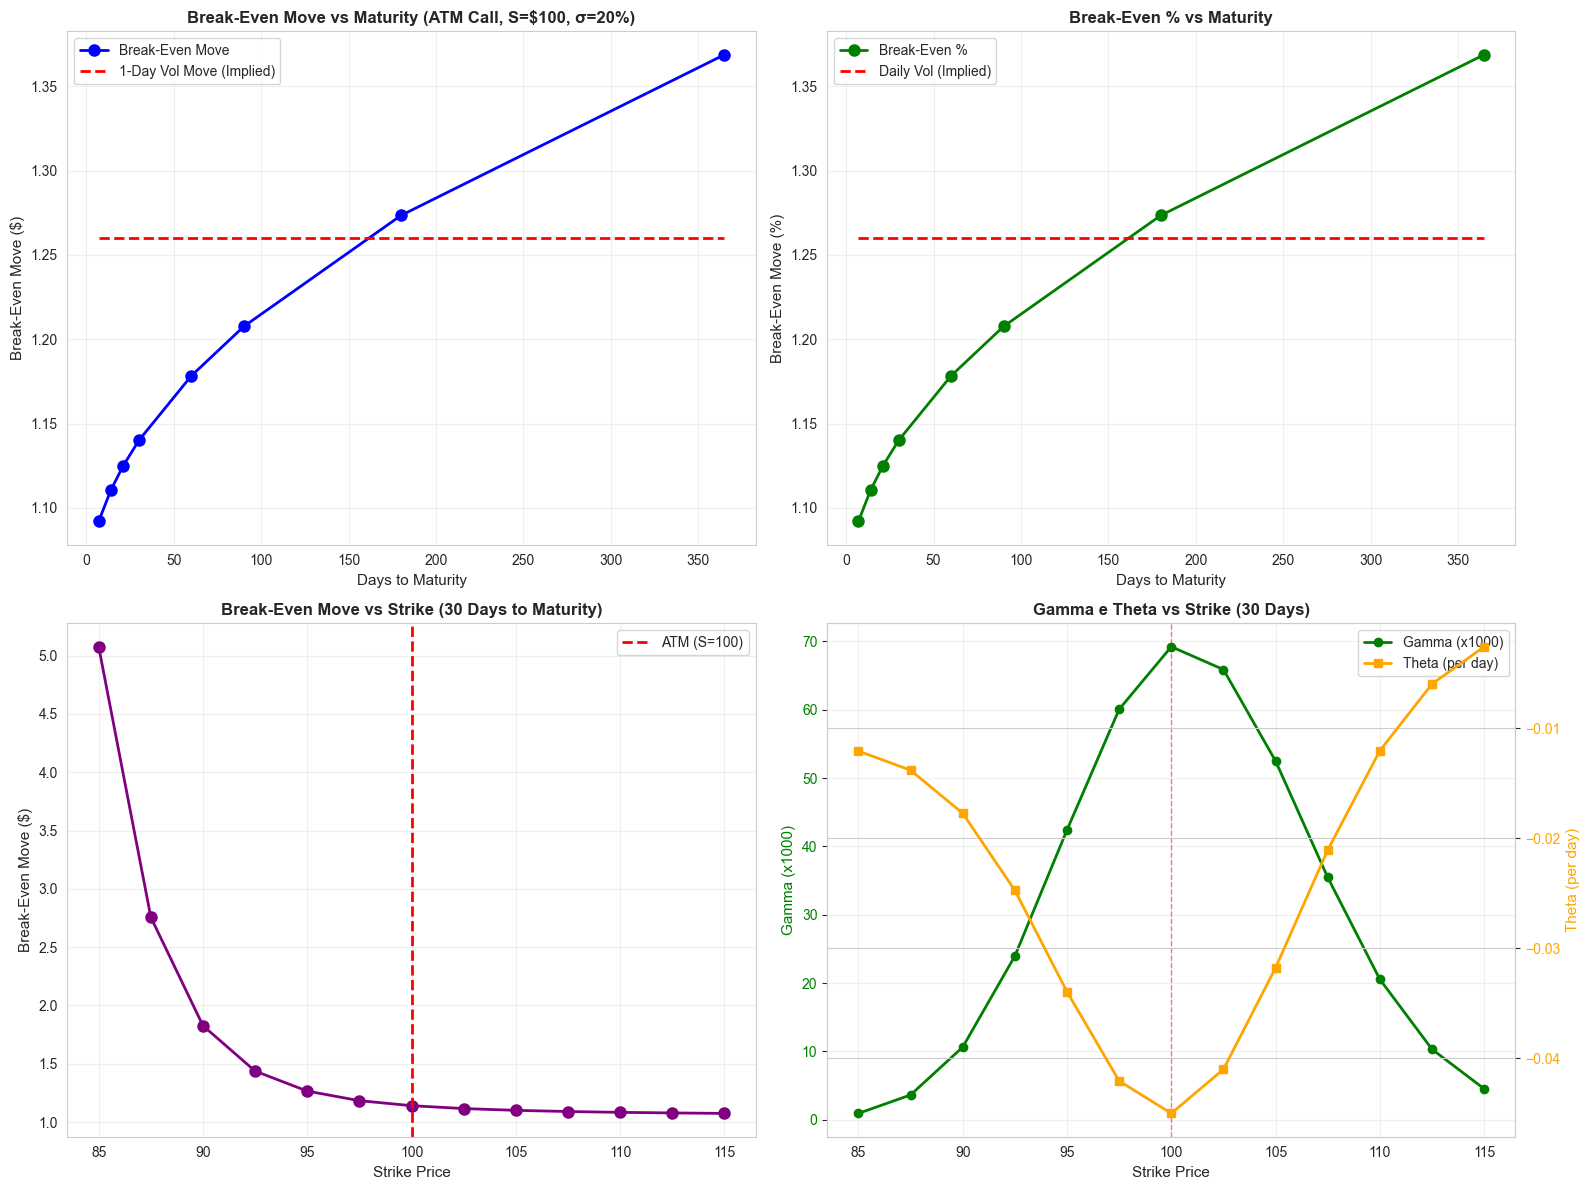

In [25]:
# Visualizzazione: Replica Figura 3.10
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Grafico 1: Break-Even Move vs Maturity
ax1 = axes[0, 0]
ax1.plot(df_maturity['Days'], df_maturity['BE_Move'], 'b-o', linewidth=2, markersize=8, label='Break-Even Move')
ax1.plot(df_maturity['Days'], df_maturity['Daily_Vol_Impl'] * S / 100, 'r--', linewidth=2, label='1-Day Vol Move (Implied)')
ax1.set_xlabel('Days to Maturity', fontsize=11)
ax1.set_ylabel('Break-Even Move ($)', fontsize=11)
ax1.set_title('Break-Even Move vs Maturity (ATM Call, S=$100, σ=20%)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Grafico 2: Break-Even Move % vs Maturity
ax2 = axes[0, 1]
ax2.plot(df_maturity['Days'], df_maturity['BE_Move_Pct'], 'g-o', linewidth=2, markersize=8, label='Break-Even %')
ax2.plot(df_maturity['Days'], df_maturity['Daily_Vol_Impl'], 'r--', linewidth=2, label='Daily Vol (Implied)')
ax2.set_xlabel('Days to Maturity', fontsize=11)
ax2.set_ylabel('Break-Even Move (%)', fontsize=11)
ax2.set_title('Break-Even % vs Maturity', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Grafico 3: Break-Even Move vs Strike
ax3 = axes[1, 0]
ax3.plot(df_strike['Strike'], df_strike['BE_Move'], 'purple', linewidth=2, marker='o', markersize=8)
ax3.axvline(x=S, color='red', linestyle='--', linewidth=2, label='ATM (S=100)')
ax3.set_xlabel('Strike Price', fontsize=11)
ax3.set_ylabel('Break-Even Move ($)', fontsize=11)
ax3.set_title('Break-Even Move vs Strike (30 Days to Maturity)', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Grafico 4: Gamma e Theta vs Strike
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()

line1 = ax4.plot(df_strike['Strike'], df_strike['Gamma']*1000, 'g-', linewidth=2, marker='o', markersize=6, label='Gamma (x1000)')
ax4.axvline(x=S, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xlabel('Strike Price', fontsize=11)
ax4.set_ylabel('Gamma (x1000)', color='g', fontsize=11)
ax4.tick_params(axis='y', labelcolor='g')

line2 = ax4_twin.plot(df_strike['Strike'], df_strike['Theta'], 'orange', linewidth=2, marker='s', markersize=6, label='Theta (per day)')
ax4_twin.set_ylabel('Theta (per day)', color='orange', fontsize=11)
ax4_twin.tick_params(axis='y', labelcolor='orange')

ax4.set_title('Gamma e Theta vs Strike (30 Days)', fontsize=12, fontweight='bold')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax4.legend(lines, labels, loc='upper right', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 12. Analisi del P&L: Gamma vs Theta ogni Giorno

Simuliamo un path specifico e analizziamo **giorno per giorno**:
- Quanto si è mosso il sottostante
- Il P&L dal Gamma
- Il P&L dal Theta
- Il P&L netto giornaliero


In [26]:
def gamma_vs_theta_daily_analysis(S0, K, T, r, sigma_implied, sigma_realized, n_steps, seed=42):
    """
    Simula una strategia e analizza il P&L giornaliero da Gamma vs Theta
    """
    # Simula il path del sottostante
    prices, times = simulate_gbm(S0, r, sigma_realized, T, n_steps, seed)
    
    results = []
    
    for i in range(n_steps):
        S_today = prices[i]
        S_tomorrow = prices[i + 1]
        t_today = times[i]
        t_tomorrow = times[i + 1]
        
        ttm_today = T - t_today
        ttm_tomorrow = T - t_tomorrow
        dt = t_tomorrow - t_today
        
        if ttm_today <= 0:
            break
        
        # Greeks oggi
        gamma_today = gamma(S_today, K, ttm_today, r, sigma_implied)
        theta_today = theta_call(S_today, K, ttm_today, r, sigma_implied)
        
        # Movimento del sottostante
        dS = S_tomorrow - S_today
        dS_pct = (dS / S_today) * 100
        
        # Calcola il break-even move
        be_move = np.sqrt(2 * abs(theta_today) / gamma_today) if gamma_today > 0 else 0
        be_move_pct = (be_move / S_today) * 100
        
        # P&L dal Gamma (approssimato)
        gamma_pnl = 0.5 * gamma_today * (dS ** 2)
        
        # P&L dal Theta
        theta_pnl = theta_today  # Già giornaliero e negativo
        
        # P&L netto (Gamma + Theta)
        net_pnl = gamma_pnl + theta_pnl
        
        # Il movimento è stato sufficiente?
        move_sufficient = abs(dS) >= be_move
        
        results.append({
            'Day': i + 1,
            'Time': t_today,
            'S': S_today,
            'dS': dS,
            'dS_pct': dS_pct,
            'Abs_dS': abs(dS),
            'Abs_dS_pct': abs(dS_pct),
            'Gamma': gamma_today,
            'Theta': theta_today,
            'BE_Move': be_move,
            'BE_Move_Pct': be_move_pct,
            'Gamma_PnL': gamma_pnl,
            'Theta_PnL': theta_pnl,
            'Net_PnL': net_pnl,
            'Move_Sufficient': move_sufficient
        })
    
    return pd.DataFrame(results)

# Esegui l'analisi giornaliera
S0 = 100.0
K = 100.0
T = 30 / 365  # 30 giorni
r = 0.05
sigma_impl = 0.20
sigma_real = 0.30  # Alta volatilità realizzata
n_steps = 30

df_daily = gamma_vs_theta_daily_analysis(S0, K, T, r, sigma_impl, sigma_real, n_steps, seed=42)

print("="*120)
print("ANALISI GIORNALIERA: Gamma P&L vs Theta P&L")
print("="*120)
print(f"Opzione: Call ATM, Strike = ${K}, Maturity = 30 giorni")
print(f"Volatilità Implicita: {sigma_impl*100:.1f}% | Volatilità Realizzata: {sigma_real*100:.1f}%")
print("="*120)
print(f"{'Day':<5} {'Stock':<8} {'Move $':<10} {'Move %':<10} {'BE %':<10} {'Suff?':<7} {'Gamma P&L':<12} {'Theta P&L':<12} {'Net P&L':<12}")
print("-"*120)

for idx, row in df_daily.head(15).iterrows():
    suff_marker = "✓" if row['Move_Sufficient'] else "✗"
    print(f"{row['Day']:<5.0f} ${row['S']:<7.2f} {row['dS']:>+9.3f} {row['dS_pct']:>+9.3f}% {row['BE_Move_Pct']:>9.3f}% "
          f"{suff_marker:>5}   ${row['Gamma_PnL']:>10.4f}  ${row['Theta_PnL']:>10.4f}  ${row['Net_PnL']:>10.4f}")

print("-"*120)
print(f"\nTotale Gamma P&L:  ${df_daily['Gamma_PnL'].sum():>10.4f}")
print(f"Totale Theta P&L:  ${df_daily['Theta_PnL'].sum():>10.4f}")
print(f"P&L Netto Totale:  ${df_daily['Net_PnL'].sum():>10.4f}")
print(f"\nGiorni con movimento sufficiente: {df_daily['Move_Sufficient'].sum()}/{len(df_daily)} ({df_daily['Move_Sufficient'].sum()/len(df_daily)*100:.1f}%)")
print("="*120)


ANALISI GIORNALIERA: Gamma P&L vs Theta P&L
Opzione: Call ATM, Strike = $100.0, Maturity = 30 giorni
Volatilità Implicita: 20.0% | Volatilità Realizzata: 30.0%
Day   Stock    Move $     Move %     BE %       Suff?   Gamma P&L    Theta P&L    Net P&L     
------------------------------------------------------------------------------------------------------------------------
1     $100.00     +0.784    +0.784%     1.140%     ✗   $    0.0213  $   -0.0450  $   -0.0237
2     $100.78     -0.217    -0.216%     1.149%     ✗   $    0.0016  $   -0.0458  $   -0.0442
3     $100.57     +1.029    +1.024%     1.145%     ✗   $    0.0372  $   -0.0465  $   -0.0093
4     $101.60     +2.460    +2.422%     1.160%     ✓   $    0.2028  $   -0.0465  $    0.1563
5     $104.06     -0.380    -0.366%     1.219%     ✗   $    0.0037  $   -0.0407  $   -0.0370
6     $103.68     -0.379    -0.366%     1.206%     ✗   $    0.0039  $   -0.0424  $   -0.0385
7     $103.30     +2.595    +2.512%     1.194%     ✓   $    0.1953

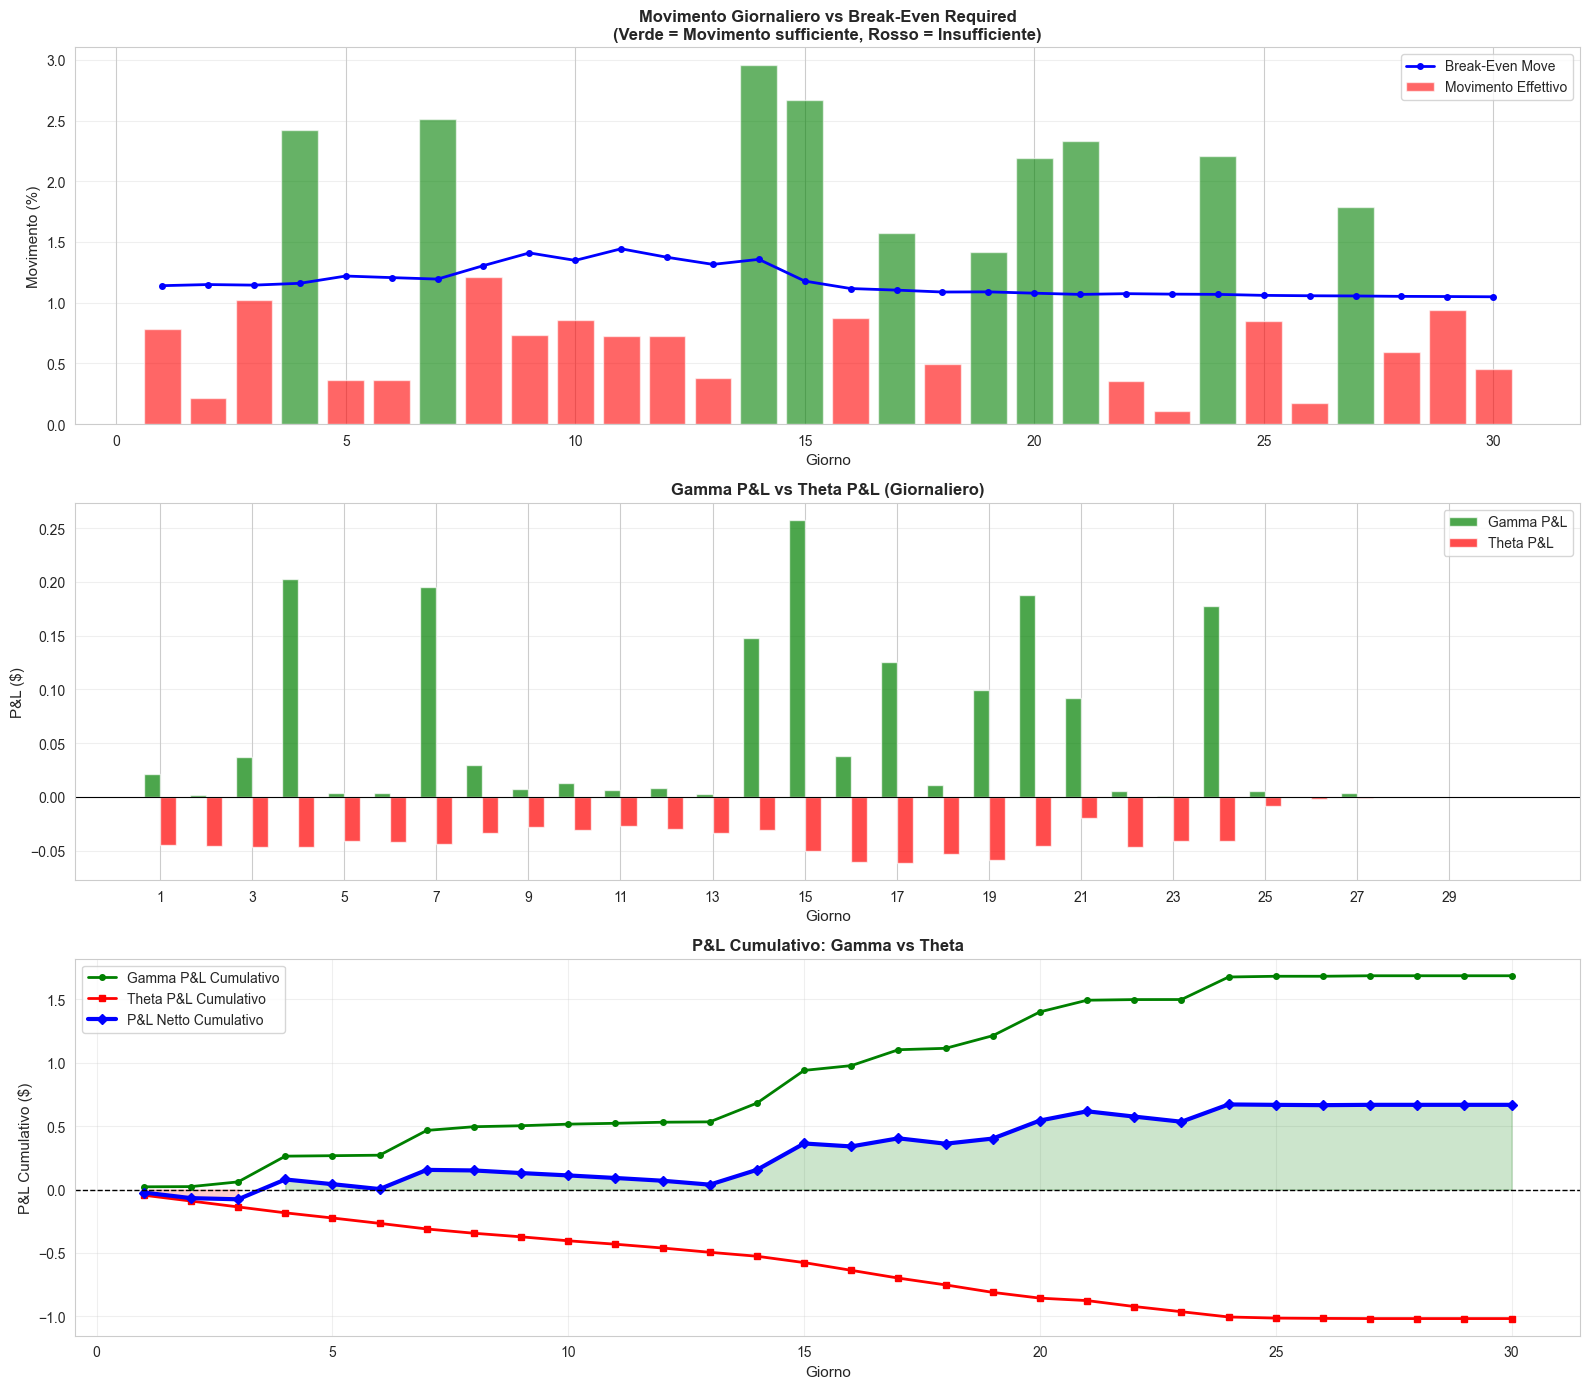

In [27]:
# Visualizzazione dell'analisi giornaliera
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Grafico 1: Movimento giornaliero vs Break-Even
ax1 = axes[0]
days = df_daily['Day']
ax1.bar(days, df_daily['Abs_dS_pct'], alpha=0.6, color=['green' if x else 'red' for x in df_daily['Move_Sufficient']], 
        label='Movimento Effettivo')
ax1.plot(days, df_daily['BE_Move_Pct'], 'b-', linewidth=2, marker='o', markersize=4, label='Break-Even Move')
ax1.set_xlabel('Giorno', fontsize=11)
ax1.set_ylabel('Movimento (%)', fontsize=11)
ax1.set_title('Movimento Giornaliero vs Break-Even Required\n(Verde = Movimento sufficiente, Rosso = Insufficiente)', 
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Grafico 2: Gamma P&L vs Theta P&L giornaliero
ax2 = axes[1]
width = 0.35
x = np.arange(len(days))
bars1 = ax2.bar(x - width/2, df_daily['Gamma_PnL'], width, label='Gamma P&L', color='green', alpha=0.7)
bars2 = ax2.bar(x + width/2, df_daily['Theta_PnL'], width, label='Theta P&L', color='red', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Giorno', fontsize=11)
ax2.set_ylabel('P&L ($)', fontsize=11)
ax2.set_title('Gamma P&L vs Theta P&L (Giornaliero)', fontsize=12, fontweight='bold')
ax2.set_xticks(x[::2])
ax2.set_xticklabels(days[::2])
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Grafico 3: P&L Netto Cumulativo
ax3 = axes[2]
cumulative_gamma = df_daily['Gamma_PnL'].cumsum()
cumulative_theta = df_daily['Theta_PnL'].cumsum()
cumulative_net = df_daily['Net_PnL'].cumsum()

ax3.plot(days, cumulative_gamma, 'g-', linewidth=2, marker='o', markersize=4, label='Gamma P&L Cumulativo')
ax3.plot(days, cumulative_theta, 'r-', linewidth=2, marker='s', markersize=4, label='Theta P&L Cumulativo')
ax3.plot(days, cumulative_net, 'b-', linewidth=3, marker='D', markersize=5, label='P&L Netto Cumulativo')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel('Giorno', fontsize=11)
ax3.set_ylabel('P&L Cumulativo ($)', fontsize=11)
ax3.set_title('P&L Cumulativo: Gamma vs Theta', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.fill_between(days, 0, cumulative_net, where=(cumulative_net >= 0), alpha=0.2, color='green')
ax3.fill_between(days, 0, cumulative_net, where=(cumulative_net < 0), alpha=0.2, color='red')

plt.tight_layout()
plt.show()


## 13. Confronto con Diverse Volatilità Realizzate

Vediamo come cambia il numero di giorni con "movimento sufficiente" al variare della volatilità realizzata:


In [28]:
# Test con diverse volatilità realizzate
sigma_real_levels = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]
results_vol_comparison = []

for sigma_real in sigma_real_levels:
    df_temp = gamma_vs_theta_daily_analysis(S0, K, T, r, sigma_impl, sigma_real, n_steps, seed=42)
    
    pct_sufficient = (df_temp['Move_Sufficient'].sum() / len(df_temp)) * 100
    avg_daily_move = df_temp['Abs_dS_pct'].mean()
    total_gamma_pnl = df_temp['Gamma_PnL'].sum()
    total_theta_pnl = df_temp['Theta_PnL'].sum()
    total_net_pnl = df_temp['Net_PnL'].sum()
    
    results_vol_comparison.append({
        'Realized_Vol': sigma_real * 100,
        'Avg_Daily_Move': avg_daily_move,
        'Pct_Days_Sufficient': pct_sufficient,
        'Total_Gamma_PnL': total_gamma_pnl,
        'Total_Theta_PnL': total_theta_pnl,
        'Total_Net_PnL': total_net_pnl
    })

df_vol_comp = pd.DataFrame(results_vol_comparison)

print("\n" + "="*110)
print("CONFRONTO: Effetto della Volatilità Realizzata sul Break-Even")
print("="*110)
print(f"Volatilità Implicita fissa: {sigma_impl*100:.1f}%")
print("="*110)
print(f"{'Vol Real':<10} {'Avg Move %':<12} {'% Days BE':<12} {'Gamma P&L':<14} {'Theta P&L':<14} {'Net P&L':<14}")
print("-"*110)

for idx, row in df_vol_comp.iterrows():
    print(f"{row['Realized_Vol']:>6.1f}%   {row['Avg_Daily_Move']:>10.3f}%  {row['Pct_Days_Sufficient']:>10.1f}%  "
          f"${row['Total_Gamma_PnL']:>12.4f}  ${row['Total_Theta_PnL']:>12.4f}  ${row['Total_Net_PnL']:>12.4f}")

print("="*110)
print("\n% Days BE = Percentuale di giorni in cui il movimento è stato sufficiente per compensare il theta")



CONFRONTO: Effetto della Volatilità Realizzata sul Break-Even
Volatilità Implicita fissa: 20.0%
Vol Real   Avg Move %   % Days BE    Gamma P&L      Theta P&L      Net P&L       
--------------------------------------------------------------------------------------------------------------
  10.0%        0.380%         0.0%  $      0.3158  $     -1.7050  $     -1.3893
  15.0%        0.571%        23.3%  $      0.6323  $     -1.4590  $     -0.8267
  20.0%        0.762%        26.7%  $      0.9875  $     -1.2806  $     -0.2930
  25.0%        0.953%        33.3%  $      1.3465  $     -1.1375  $      0.2090
  30.0%        1.144%        33.3%  $      1.6847  $     -1.0173  $      0.6675
  35.0%        1.335%        43.3%  $      1.9886  $     -0.9150  $      1.0736
  40.0%        1.526%        50.0%  $      2.2559  $     -0.8279  $      1.4280

% Days BE = Percentuale di giorni in cui il movimento è stato sufficiente per compensare il theta


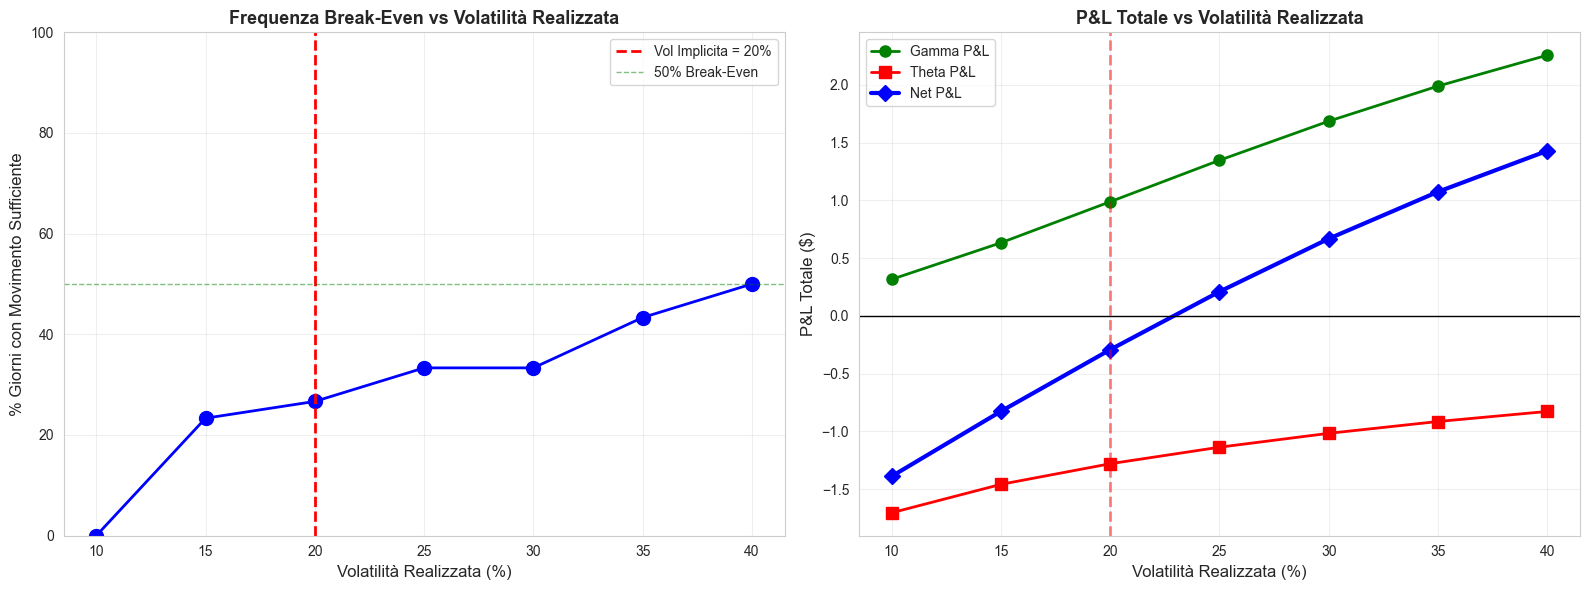

In [29]:
# Visualizzazione del confronto
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grafico 1: % Giorni con movimento sufficiente vs Vol Realizzata
ax1 = axes[0]
ax1.plot(df_vol_comp['Realized_Vol'], df_vol_comp['Pct_Days_Sufficient'], 
         'bo-', linewidth=2, markersize=10)
ax1.axvline(x=sigma_impl*100, color='r', linestyle='--', linewidth=2, label=f'Vol Implicita = {sigma_impl*100:.0f}%')
ax1.axhline(y=50, color='g', linestyle='--', linewidth=1, alpha=0.5, label='50% Break-Even')
ax1.set_xlabel('Volatilità Realizzata (%)', fontsize=12)
ax1.set_ylabel('% Giorni con Movimento Sufficiente', fontsize=12)
ax1.set_title('Frequenza Break-Even vs Volatilità Realizzata', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 100])

# Grafico 2: P&L Totale vs Vol Realizzata
ax2 = axes[1]
ax2.plot(df_vol_comp['Realized_Vol'], df_vol_comp['Total_Gamma_PnL'], 
         'g-o', linewidth=2, markersize=8, label='Gamma P&L')
ax2.plot(df_vol_comp['Realized_Vol'], df_vol_comp['Total_Theta_PnL'], 
         'r-s', linewidth=2, markersize=8, label='Theta P&L')
ax2.plot(df_vol_comp['Realized_Vol'], df_vol_comp['Total_Net_PnL'], 
         'b-D', linewidth=3, markersize=8, label='Net P&L')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.axvline(x=sigma_impl*100, color='r', linestyle='--', linewidth=2, alpha=0.5)
ax2.set_xlabel('Volatilità Realizzata (%)', fontsize=12)
ax2.set_ylabel('P&L Totale ($)', fontsize=12)
ax2.set_title('P&L Totale vs Volatilità Realizzata', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Interpretazione dei Risultati Gamma vs Theta

**Punti chiave dall'analisi:**

1. **Break-Even Move giornaliero**: 
   - È il movimento minimo necessario affinché il Gamma P&L compensi il Theta decay
   - Diminuisce all'aumentare della maturity (opzioni a lungo termine richiedono meno movimento)
   - È massimo per opzioni ATM (dove il Gamma è massimo)

2. **Relazione con la Volatilità**:
   - Il Break-Even Move è circa uguale alla volatilità giornaliera implicita
   - Formula: BE Move ≈ σ × √(dt) × S
   - Se Vol Realizzata > Vol Implicita → più giorni superano il BE → P&L positivo

3. **Trade-off Gamma/Theta**:
   - **Long Call + Delta Hedge** = Long Gamma + Short Theta
   - Guadagni quando il mercato si muove più del Break-Even
   - Perdi quando il mercato è tranquillo (il Theta domina)

4. **Applicazione pratica**:
   - Market makers calcolano continuamente questo break-even
   - Decidono se essere long/short gamma basandosi sulle aspettative di volatilità
   - Il break-even move aiuta a determinare se un'opzione è "cheap" o "expensive"


## 14. Conclusioni

Questo notebook ha replicato l'esempio di gamma trading dal Capitolo 3 di Derman, dimostrando:

1. **Long Gamma è long volatilità realizzata**: Quando si compra un'opzione e si fa delta hedging, si guadagna se la volatilità realizzata supera la volatilità implicita pagata.

2. **Il P&L dipende dalla differenza di varianza**: La formula approssimata $\text{P&L} \approx \frac{1}{2} \Gamma S^2 (\sigma_{\text{real}}^2 - \sigma_{\text{impl}}^2) T$ cattura l'essenza del gamma trading.

3. **Frequenza di rehedging**: Più frequente è il rehedging, più il risultato si avvicina alla teoria Black-Scholes (delta hedging continuo).

4. **Theta vs Gamma**: C'è un trade-off tra:
   - **Theta (time decay)**: Si paga ogni giorno
   - **Gamma P&L**: Si guadagna dal rehedging quando il mercato si muove

5. **Break-Even Move** (Figura 3.10): Il movimento giornaliero necessario per compensare il theta è:
   $$\Delta S_{\text{BE}} = \sqrt{\frac{2|\Theta|}{\Gamma}}$$
   Questo è circa uguale alla volatilità giornaliera implicita.

6. **Monte Carlo**: Le simulazioni multiple mostrano che, in media, il P&L converge verso il valore teorico, ma c'è variabilità path-dependent.

### Applicazioni pratiche:
- **Market makers**: Gestiscono il gamma risk continuamente e calcolano il break-even move
- **Volatility traders**: Cercano di sfruttare discrepanze tra vol implicita e realizzata
- **Risk management**: Comprendere il gamma è fondamentale per gestire i rischi di portafogli di opzioni
- **Trading decisions**: Il break-even move aiuta a decidere se comprare o vendere opzioni


## 11. Conclusioni

Questo notebook ha replicato l'esempio di gamma trading dal Capitolo 3 di Derman, dimostrando:

1. **Long Gamma è long volatilità realizzata**: Quando si compra un'opzione e si fa delta hedging, si guadagna se la volatilità realizzata supera la volatilità implicita pagata.

2. **Il P&L dipende dalla differenza di varianza**: La formula approssimata $\text{P&L} \approx \frac{1}{2} \Gamma S^2 (\sigma_{\text{real}}^2 - \sigma_{\text{impl}}^2) T$ cattura l'essenza del gamma trading.

3. **Frequenza di rehedging**: Più frequente è il rehedging, più il risultato si avvicina alla teoria Black-Scholes (delta hedging continuo).

4. **Theta vs Gamma**: C'è un trade-off tra:
   - **Theta (time decay)**: Si paga ogni giorno
   - **Gamma P&L**: Si guadagna dal rehedging quando il mercato si muove

5. **Monte Carlo**: Le simulazioni multiple mostrano che, in media, il P&L converge verso il valore teorico, ma c'è variabilità path-dependent.

### Applicazioni pratiche:
- **Market makers**: Gestiscono il gamma risk continuamente
- **Volatility traders**: Cercano di sfruttare discrepanze tra vol implicita e realizzata
- **Risk management**: Comprendere il gamma è fondamentale per gestire i rischi di portafogli di opzioni
